<a href="https://colab.research.google.com/github/gshah8/UCF/blob/master/Machine_Learning/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 3

The goal of this homework is to learn how to leverage pretrained convnets and to use some visualization techniques.
You will work with the data set *cats vs dogs* and use the pretrained convnet VGG19.

Experiment with different classifiers, trying to maximize the validation accuracy. You only need to show one classifier.

---









##Download the data

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-16 19:56:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   232MB/s    in 0.3s    

2019-04-16 19:56:48 (232 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

##Load the convolutional base

In [5]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

80142336/80134624 [==============================] - 1s 0us/step


## Problem 1

Do feature extraction with data augmentation.

We need to freeze the convolutional base for Problem 1

In [0]:
conv_base.trainable = False

In [13]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# no dropout
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 20s 196ms/step - loss: 0.6504 - acc: 0.6340 - val_loss: 0.5745 - val_acc: 0.7160
Epoch 2/100
100/100 [==============================] - 19s 190ms/step - loss: 0.5821 - acc: 0.7035 - val_loss: 0.4983 - val_acc: 0.7890
Epoch 3/100
100/100 [==============================] - 18s 182ms/step - loss: 0.5399 - acc: 0.7440 - val_loss: 0.4636 - val_acc: 0.7730
Epoch 4/100
100/100 [==============================] - 18s 179ms/step - loss: 0.5033 - acc: 0.7755 - val_loss: 0.4162 - val_acc: 0.8160
Epoch 5/100
100/100 [==============================] - 18s 178ms/step - loss: 0.4787 - acc: 0.7785 - val_loss: 0.4072 - val_acc: 0.8160
Epoch 6/100
100/100 [==============================] - 19s 193ms/step - loss: 0.4569 - acc: 0.8035 - val_loss: 0.3736 - val_acc: 0.8340
Epoch 7/100
100/100 [==============================] - 19s 192ms/step - loss: 0.4412 - acc: 0.7965 -

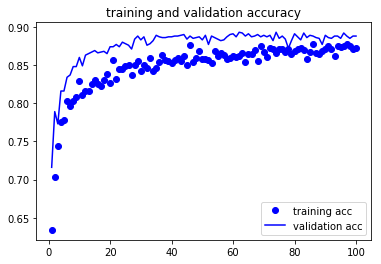

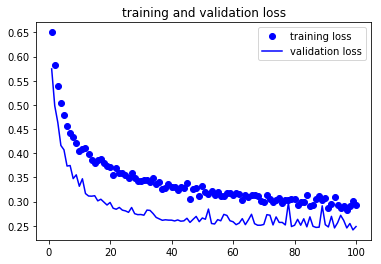

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [18]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.255029411688447
Validation accuracy: 0.8919999945163727


In [0]:
model_fname = 'cats_and_dogs_prob1.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)

## Problem 2

Do fine-tuning with data augmentation. 

## Problem 3

Visualize heatmaps of class activation for the the model obtained in Problem 2.


## Problem 4

Build an activation model that takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2. Using this activation model obtain the corresponding activations for the validation images. Apply t-SNE visualization to these activations to see how well the convnet separates cats from dogs.